<a href="https://colab.research.google.com/github/JayUsesGitHub/LiverMind/blob/main/LiverMind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
using_colab = True

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3nvkpebf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3nvkpebf
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=43ceeae0232bd52baf19856508eeda047b6e921d079470bfe0a352fcd6520271
  Stored in directory: /tmp/pip-ephem-wheel-cache-a2jqgvgn/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-11-27 00:17:20--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.

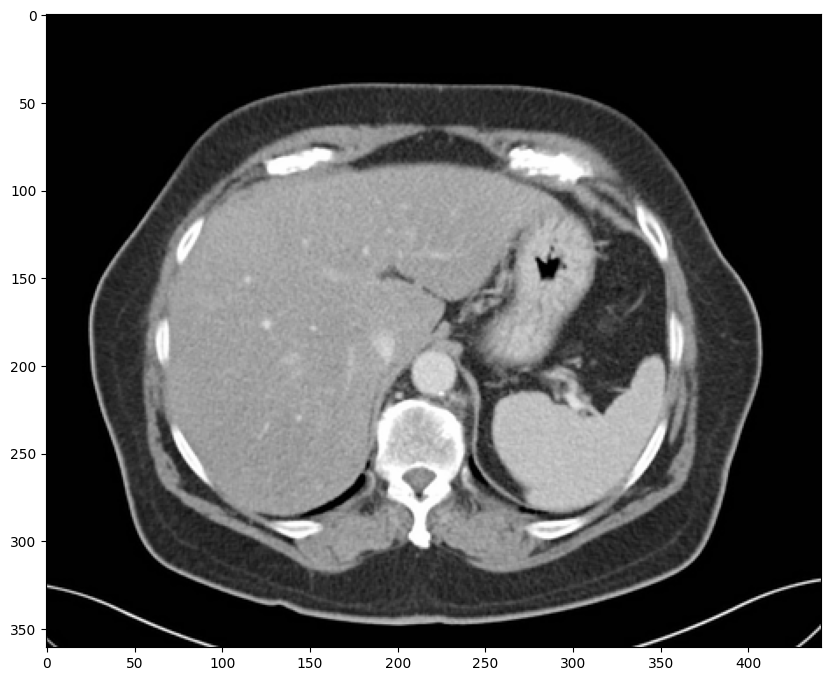

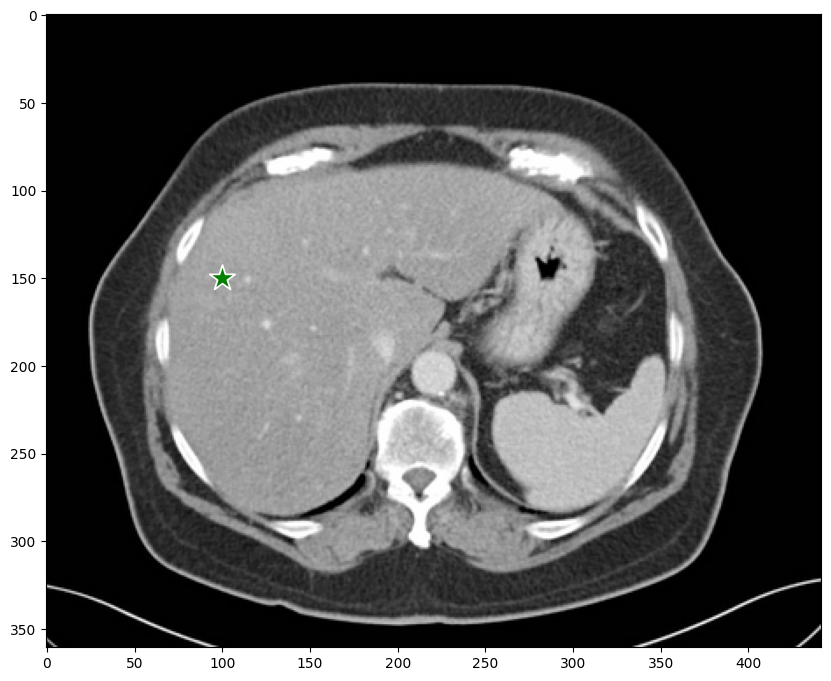

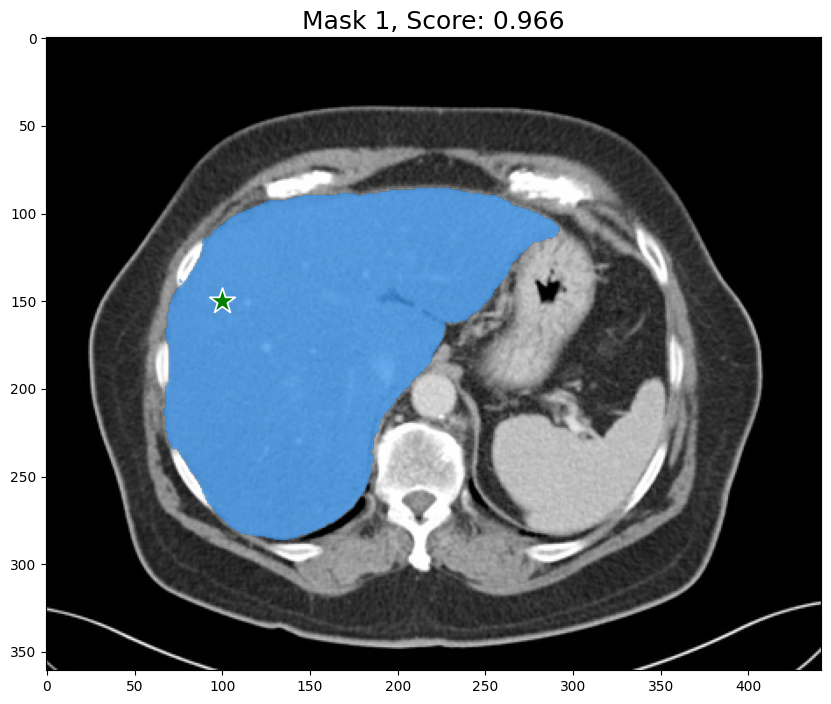

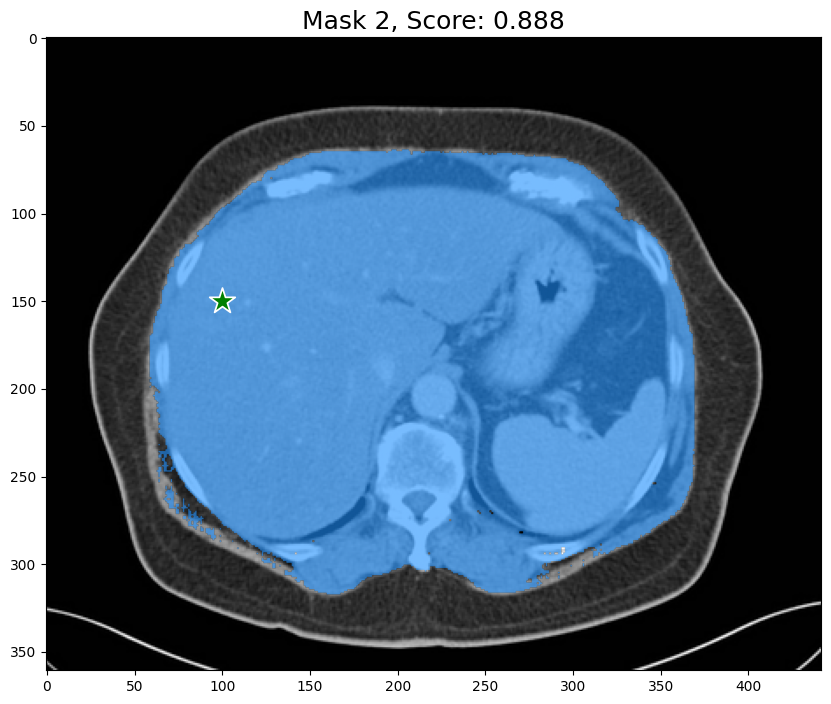

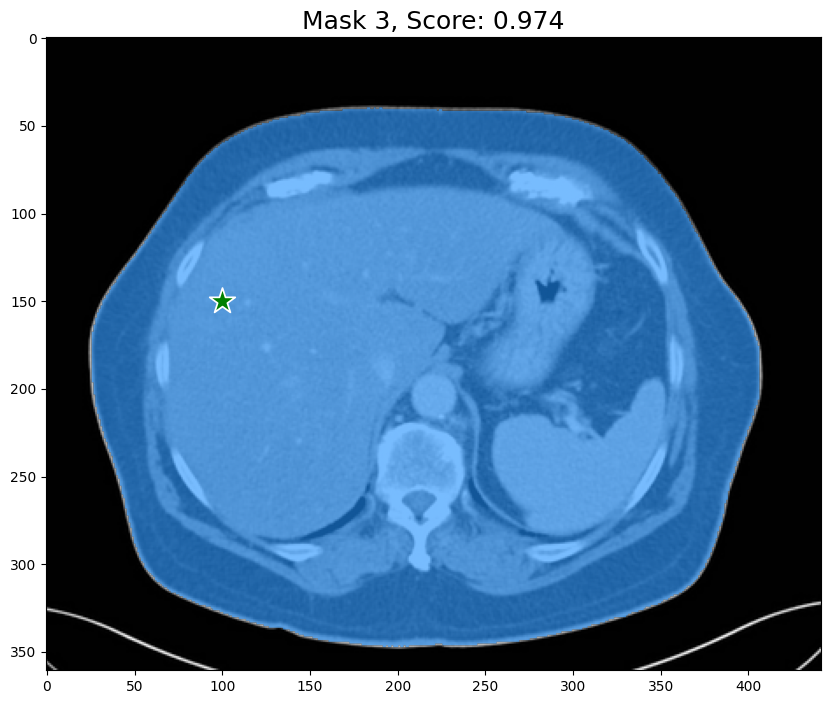

In [19]:
# libs
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# defining constants
IMAGE_PATH = '/content/images/liver_ct.png' # this is the sample image | you can add your image in the file to experiment with the segmentation
SAM_CHECKPOINT = "sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
DEVICE = "cuda"

# displays an image using matplotlib using various parameters and also overlays points, masks, and scores on the image
def load_image(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def display_image(image, points=None, labels=None, masks=None, scores=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    if points is not None and labels is not None:
        show_points(points, labels, plt.gca())

    if masks is not None and scores is not None:
        for i, (mask, score) in enumerate(zip(masks, scores)):
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            show_mask(mask, plt.gca())
            show_points(points, labels, plt.gca())
            plt.title(f"Mask {i + 1}, Score: {score:.3f}", fontsize=18)

# shows the masks and images
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def main():
    # Load image
    image = load_image(IMAGE_PATH)

    # Display original image
    display_image(image)

    # Set up SAM model
    sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
    sam.to(device=DEVICE)

    # Create predictor
    predictor = SamPredictor(sam)

    # Set image for prediction
    predictor.set_image(image)

    # Input data for prediction
    input_point = np.array([[100, 150]])
    input_label = np.array([1])

    # Make predictions
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    # Display results
    display_image(image, points=input_point, labels=input_label, masks=masks, scores=scores)

if __name__ == "__main__":
    main()